In [1]:
#libraries

import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
#import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2023-07-07 16:51:19.894410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-07 16:51:19.894430: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-07 16:51:23.254663: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-07 16:51:23.254703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marco-Lenovo-S340-15IWL): /proc/driver/nvidia/version does not exist
2023-07-07 16:51:23.255183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operatio

## Import the data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))


Number of original training examples: 60000
Number of original test examples: 10000


# Filter the 3 and 6 labels

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))


Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


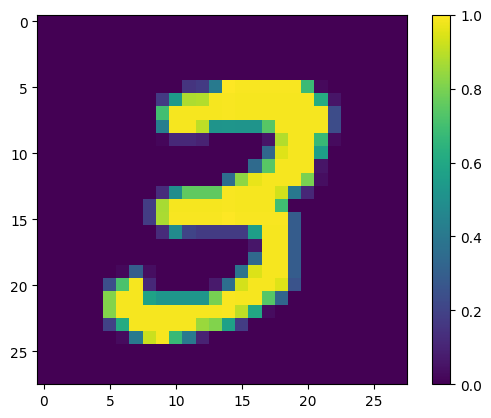

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()


## Rescale the image

In [6]:
x_train_small = tf.image.resize(x_train, (8,8)).numpy()
x_test_small = tf.image.resize(x_test, (8,8)).numpy()
x_train_small = x_train_small[0:5000]
x_test_small = x_test_small[0:500]
y_train = y_train[0:5000]
y_test = y_test[0:500]

2023-07-07 16:51:26.000991: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75571328 exceeds 10% of free system memory.


True


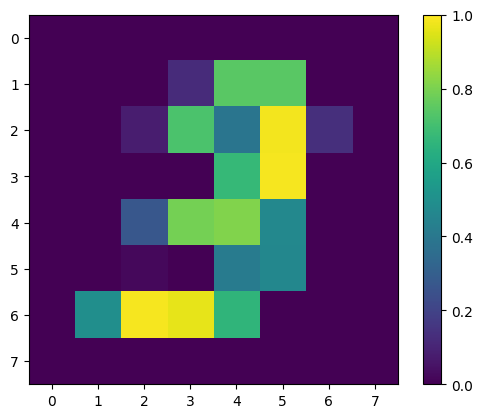

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()


## Classical Convolutional Neural Network

## CLASSICAL CNN with the same number of parameters of the QCNN

In [8]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3,3], activation='relu', input_shape=(8,8,1)))
    model.add(tf.keras.layers.Conv2D(64, [3,3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

In [9]:


notfair_nn = model.fit(x_train_small,
          y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(x_test_small, y_test))

cnn_results = model.evaluate(x_test_small, y_test)


Epoch 1/50
40/40 [==============================] - 1s 13ms/step - loss: 0.3554 - accuracy: 0.7948 - val_loss: 0.0931 - val_accuracy: 0.9640
Epoch 2/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0610 - accuracy: 0.9772 - val_loss: 0.0436 - val_accuracy: 0.9860
Epoch 3/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0354 - accuracy: 0.9874 - val_loss: 0.0335 - val_accuracy: 0.9920
Epoch 4/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0251 - accuracy: 0.9926 - val_loss: 0.0228 - val_accuracy: 0.9920
Epoch 5/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0185 - val_accuracy: 0.9920
Epoch 6/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0154 - accuracy: 0.9936 - val_loss: 0.0273 - val_accuracy: 0.9940
Epoch 7/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0166 - accuracy: 0.9934 - val_loss: 0.0185 - val_accuracy: 0.9920
Epoch 8/50
40/40 [

In [10]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(8,8,1)))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [11]:
fair_nn = model.fit(x_train_small,
          y_train,
          batch_size=128,
          epochs=50,
          verbose=2,
          validation_data=(x_test_small, y_test))

fair_nn_results = model.evaluate(x_test_small, y_test)


Epoch 1/50
40/40 - 1s - loss: 0.6288 - accuracy: 0.7098 - val_loss: 0.5910 - val_accuracy: 0.7740 - 614ms/epoch - 15ms/step
Epoch 2/50
40/40 - 0s - loss: 0.5716 - accuracy: 0.8172 - val_loss: 0.5429 - val_accuracy: 0.8400 - 66ms/epoch - 2ms/step
Epoch 3/50
40/40 - 0s - loss: 0.5254 - accuracy: 0.8760 - val_loss: 0.5043 - val_accuracy: 0.8980 - 65ms/epoch - 2ms/step
Epoch 4/50
40/40 - 0s - loss: 0.4871 - accuracy: 0.9048 - val_loss: 0.4731 - val_accuracy: 0.9160 - 66ms/epoch - 2ms/step
Epoch 5/50
40/40 - 0s - loss: 0.4562 - accuracy: 0.9216 - val_loss: 0.4473 - val_accuracy: 0.9240 - 68ms/epoch - 2ms/step
Epoch 6/50
40/40 - 0s - loss: 0.4300 - accuracy: 0.9350 - val_loss: 0.4253 - val_accuracy: 0.9320 - 68ms/epoch - 2ms/step
Epoch 7/50
40/40 - 0s - loss: 0.4077 - accuracy: 0.9454 - val_loss: 0.4054 - val_accuracy: 0.9380 - 68ms/epoch - 2ms/step
Epoch 8/50
40/40 - 0s - loss: 0.3881 - accuracy: 0.9504 - val_loss: 0.3878 - val_accuracy: 0.9500 - 75ms/epoch - 2ms/step
Epoch 9/50
40/40 - 0s 

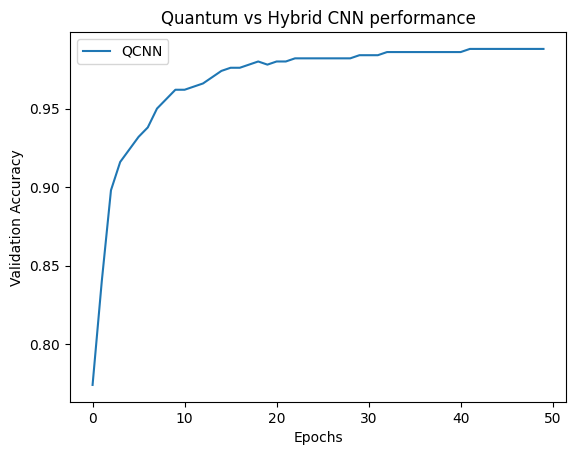

In [12]:
plt.plot(fair_nn.history['val_accuracy'], label='QCNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()


ll = np.loadtxt("3loss.txt")
vl = np.loadtxt("3val_loss.txt")


q = np.loadtxt("3val_acc.txt")[0:50]
c = fair_nn.history['val_accuracy']
cc = notfair_nn.history['val_accuracy']

qnn_accuracy = np.mean(q[30:])
cnn_accuracy = np.mean(cc[30:])
fair_nn_accuracy = np.mean(c[30:])





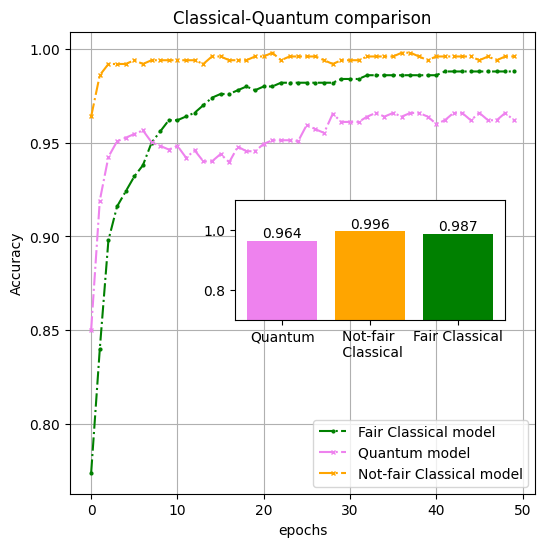

In [13]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))


axLL.plot(c,"-.", marker= "o", markersize=2, label = "Fair Classical model", color="green")
axLL.plot(q,"-.", marker= "x", markersize=3, label = "Quantum model", color="violet")
axLL.plot(cc,"-.", marker= "x", markersize=3, label = "Not-fair Classical model", color="orange")

axLL.set_xlabel("epochs")
axLL.set_ylabel("Accuracy")
axLL.legend(loc = 'best')
axLL.set_title("Classical-Quantum comparison")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")
l, b, h, w = .4, .4, .2, .45
ax3 = fig.add_axes([l, b, w, h])
plt.ylim(0.7, 1.1)
x = ["Quantum", "Not-fair \n Classical", "Fair Classical"]
y = [qnn_accuracy, cnn_accuracy, fair_nn_accuracy]
plt.bar(x,y, color=("violet","orange","green" ))
# Adding labels to each bar

for i in range(len(x)):
    plt.text(x[i], y[i], '{:.3f}'.format(y[i]), ha='center', va='bottom')
    
fig.savefig('3c.pdf')

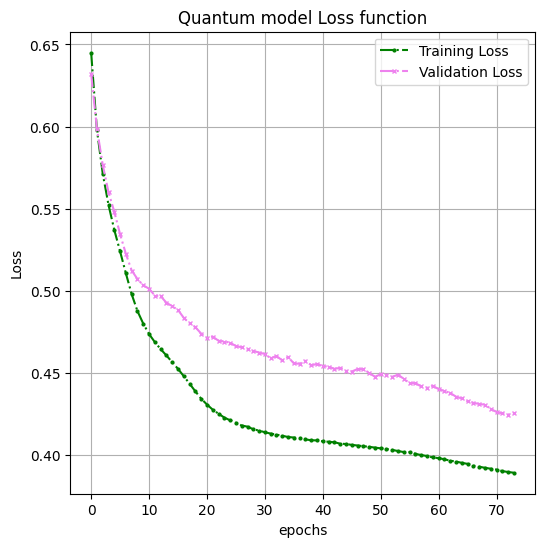

In [14]:
fig, axLL = plt.subplots(1, 1 , figsize=(6, 6))


axLL.plot(ll,"-.", marker= "o", markersize=2, label = "Training Loss", color="green")
axLL.plot(vl,"-.", marker= "x", markersize=3, label = "Validation Loss", color="violet")

axLL.set_xlabel("epochs")
axLL.set_ylabel("Loss")
axLL.legend(loc = 'best')
axLL.set_title("Quantum model Loss function")
#axLL.set_ylim(-5.7,-5.1)
#plt.ylim(-0.2,0.1)
axLL.grid(True, which= "both")

fig.savefig('3l.pdf')